## Stepper-Motor-Driver-using-RL78
---

This application note shows how to implement a controller for a stepper motor using the RL78 Hardware 16-Bit Single-Chip Microcontrollers (MCUs) along with a simple analog Drive circuit. Nowadays, stepper motors are used in a wide variety of applications. They are prevalent in consumer office equipment such as printers, scanners, copiers and plotters. They also play an important role in the industry, use in robotics or dashboard indicators, climate control systems in the automotive industry.

Purpose of this application note is to show how a stepper motor control is realised on the RL78/G13
with as few external parts as possible. The software and hardware configuration published here is
just a academic project (EL9630/NEA630 - Microprocessors) and are not intend for mass production.

### Stepper Motor Basics
---

A step motor is an electromagnetic, rotary actuator, which mechanically converts digital pulse inputs to
incremental shaft rotation. The rotation has not only a direct relation to the number of input pulses, but
its speed is related to the frequency of the pulses. 

#### Hybrid Stepper Motor
---

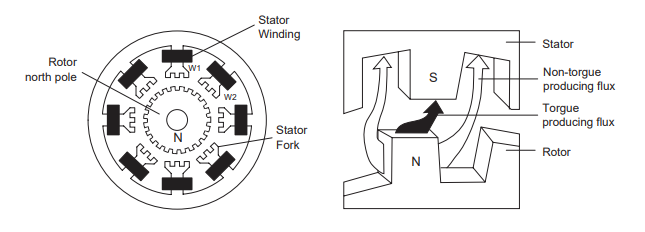

The drive topology of stepper motors is also an important criterion for choosing a motor.
Here are two main topologies to mention, unipolar and bipolar driving. Unipolar stepping motors are composed of two windings, each with a center tap. The center taps are either brought outside the motor as two separate wires or connected to each other internally and brought outside the motor as one wire. As a result, unipolar motors have 5 or 6 wires. Regardless of the
number of wires, unipolar motors are driven in the same way. The center tap wire(s) is tied to a power supply and the ends of the coils are alternately grounded.

#### 2 Phase Stepper Motor with one pole pair permanent magnet
---

Unipolar stepping motors operate by attracting the north or south poles of the permanently magnetized rotor to the stator poles. Thus, in these motors, the direction of the current through the stator windings determines which rotor poles will be attracted to which stator poles. Current direction in unipolar motors is dependent on which half of a winding is energized. Physically, the halves of the windings are wound
parallel to one another. Therefore, one winding acts as either a north or south pole depending on which
half is powered.

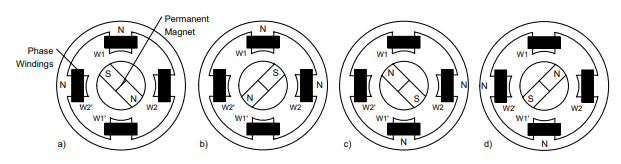

In the figure above you can see the four different energizing phases that are necessary to rotate the shaft one time. In the first phase W1 and W2’ are energized, in the second the current flows through W1 and W2 etc. In this application design a variant where two windings are energized at the same time has been chosen to produce more torque. The following figure shows the different energizing states for the
example motor above.

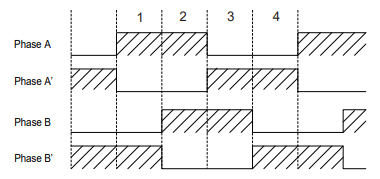

The full step modus is already shown in the example above, means that you need four steps in the simplest arrangements to obtain one shaft rotation. The angular resolution is 90 degrees. The difference of the half step operation lies in the fact that the phase coils are not always energized at the same time, but, as the associated figure shows also is switched off. Thus each step is halved, so that for a revolution 8 steps are necessary. The stepper angle halved itself thus on 45 degrees.

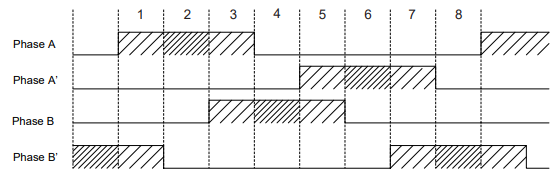

#### Stepper Motor Control Requirements | Unipolar Stepper Motor drive
---

As already mentioned this application design deals with an unipolar drive topology and focuses on the full and half-step operation mode. The principal driver design for an unipolar stepper motor is shown below.

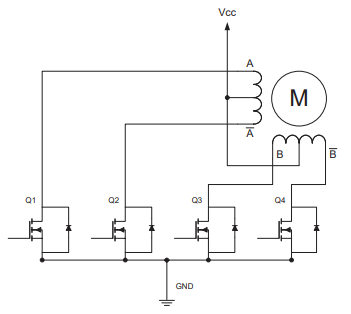

The following figure shows a schematic for general motor control design with a microcontroller.

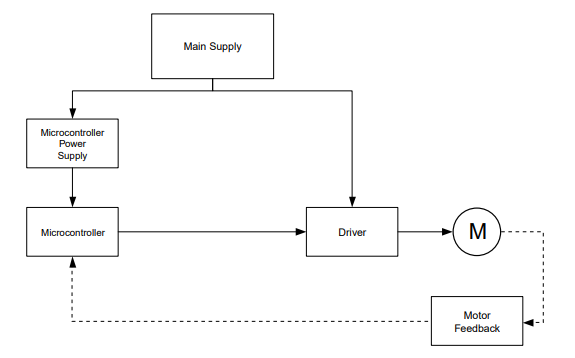

The functions of the components in detail:

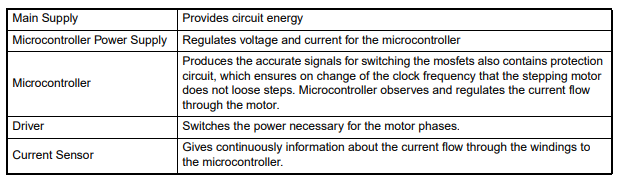

Stepper motor control requirements are summarized below:

• Driver circuit to provide necessary power for the stepper motor

• Current limiting device (software based)

• Interrupted based microcontroller algorithm to produce exact output signals